# Análise comparativa entre os itens de projetos culturais
---

**Objetivo:** realizar uma análise comparativa entre os itens de um projeto específico com os itens dos outros projetos culturais de um mesmo segmento. Nesta análise, será investigada a porcentagem de itens de um projeto que estão entre os itens mais frequentes de seu segmento.

#### Importando módulos necessários

In [16]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df.columns)
df.head()

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto,cdCidade,cdEtapa
0,121051,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,Unidade,150,40.0,1.0,150.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
1,121051,100855,792883,Bonecos – Criação,3599,Verba,90,1.0,1.0,4000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
2,121051,100855,792903,Produtor executivo,53,Verba,90,3.0,1.0,3000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,355030,2
3,119968,98671,109095,Assistente de produção,1037,Verba,30,1.0,1.0,1000.0,...,1 - Pré-Produção / Preparação,3,Música,31,Música Popular Cantada,51,Apresentação Musical,2009-12-28 11:37:57.830,330455,1
4,112836,91695,116511,Designer,103,Mês,378,1.0,18.0,2000.0,...,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,17,Pesquisa,2009-05-21 10:48:48.790,431490,2


#### Gerando tabela com o número de ocorrências de itens por segmento

In [3]:
items = df[['PRONAC', 'idSegmento', 'idPlanilhaItens']].drop_duplicates()
items_occurrences = items.groupby(['idSegmento', 'idPlanilhaItens']).count()
items_occurrences = items_occurrences.rename(columns={'PRONAC': 'itemOccurrences'})
items_occurrences.head()

itemOccurrences
idSegmento idPlanilhaItens                 
11         10                           526
           12                           594
           13                           763
           14                            12
           15                           513

#### Gerando tabela com o número de projetos por segmento

In [4]:
num_projects = items.drop('idPlanilhaItens', axis=1).set_index('idSegmento').drop_duplicates()
num_projects = num_projects.groupby('idSegmento').count()
num_projects = num_projects.rename(columns={'PRONAC': 'numProjects'})
num_projects.head()

,numProjects
idSegmento,
11,9793
12,2415
13,415
14,128
15,4


## Estudo de caso: análise de um projeto específico
---

Escolheu-se aleatoriamente um projeto cultural para analisar seus itens com relação aos itens mais comuns de seu segmento.

#### Escolhendo um projeto e gerando sua lista de itens

In [5]:
pronac = 90105
project_items = items[items['PRONAC'] == pronac]
project = project_items.iloc[0]
project_items = project_items.drop(columns=['PRONAC', 'idSegmento'])
project_items = project_items.values[:,0]
project_items

array([  74,   67,   49,   73,   61, 2605,  178,   12,   72,  143, 2620,
         68,   85, 2634,  118,   62,  142,  206,  192,   63,   23,   27,
         71, 2632,   24,  150,   81,  201, 1219, 2692, 2631, 1002,   57,
       1120,   53,   75,  179,   83, 1037, 2715, 2611, 1050, 2667,   66,
       2695,  191,  144, 2633,   40,   22,  117,  189, 2639,  134])

#### Obtendo a lista dos itens do segmento do projeto escolhido e ordenando-os por seus números de ocorrências

(1359, 1)


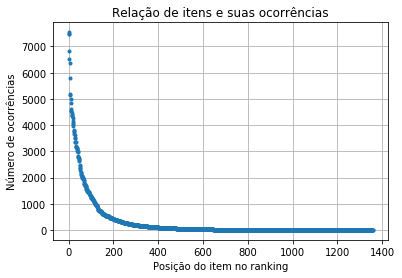

In [6]:
segment = project['idSegmento']
items_segment = items_occurrences.reset_index('idPlanilhaItens').loc[segment]
items_segment = items_segment.reset_index('idSegmento', drop=True)
items_segment = items_segment.set_index('idPlanilhaItens')
items_segment = items_segment.sort_values(by=['itemOccurrences'], ascending=False)
print(items_segment.shape)

plt.plot(items_segment['itemOccurrences'].values, '.')
plt.title('Relação de itens e suas ocorrências')
plt.ylabel('Número de ocorrências')
plt.xlabel('Posição do item no ranking')
plt.grid(True)

#### Obtendo a lista dos itens mais comuns do segmento

In [7]:
top_items_segment = items_segment.iloc[:len(items_segment)//10]
top_items_segment = top_items_segment.drop(columns=['itemOccurrences'])
top_items_segment = top_items_segment.reset_index('idPlanilhaItens')
print(top_items_segment.shape)
top_items_segment.head()

(135, 1)


,idPlanilhaItens
0,142
1,5249
2,191
3,2743
4,53


#### Calculando a porcentagem de itens do projeto escolhido que estão entre os itens mais comuns

In [8]:
found_in_top = sum(top_items_segment.isin(project_items))[0]
total_items = len(project_items)
print('Itens entre os mais ocorridos: {}'.format(found_in_top))
print('Número de itens do projeto: {}'.format(total_items))
print('Razão: %.2f' % (found_in_top / total_items))

Itens entre os mais ocorridos: 44
Número de itens do projeto: 54
Razão: 0.81


## Análise por segmento
---

Escolheu-se aleatoriamente um segmento para analisar a relação entre os itens de cada projeto com os mais comuns do segmento.

#### Definindo funções para encontrar os itens mais comuns de um segmento e calcular as métricas definidas acima

In [9]:
def top_items_segment(segment, percentage=0.1):
    items_segment = items_occurrences.reset_index('idPlanilhaItens').loc[segment]
    items_segment = items_segment.reset_index('idSegmento', drop=True)
    items_segment = items_segment.set_index('idPlanilhaItens')
    items_segment = items_segment.sort_values(by=['itemOccurrences'], ascending=False)
    
    top_items_segment = items_segment.iloc[:int(len(items_segment)*percentage)]
    top_items_segment = top_items_segment.drop(columns=['itemOccurrences'])
    top_items_segment = top_items_segment.reset_index('idPlanilhaItens')

    return top_items_segment

def perc_items_in_top(pronac, top_items_segment):
    project_items = items[items['PRONAC'] == pronac]
    project = project_items.iloc[0]
    project_items = project_items.drop(columns=['PRONAC', 'idSegmento'])
    project_items = project_items.values[:,0]
    
    found_in_top = sum(top_items_segment.isin(project_items))[0]
    total_items = len(project_items)
    
    return found_in_top / total_items

#### Calculando as métricas de porcentagem de itens para todos os projetos do segmento escolhido

In [10]:
segment = '11'
segment_projects = items[items['idSegmento'] == segment]
segment_projects = segment_projects.drop_duplicates(['PRONAC'])
segment_projects = segment_projects['PRONAC'].values
print(len(segment_projects), segment_projects)

%time top_items = top_items_segment(segment)
%time segment_projects = pd.Series([perc_items_in_top(project, top_items) for project in segment_projects])

9793 [100855  97310  90105 ... 124219 133676 170708]
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 21.1 ms
CPU times: user 1min 39s, sys: 72 ms, total: 1min 39s
Wall time: 1min 40s


#### Gerando gráficos dos resultados encontrados

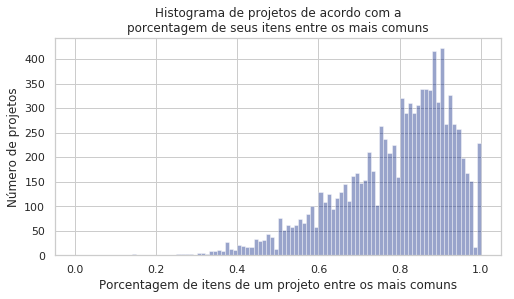

In [33]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(8,4))

sns.distplot(segment_projects, bins=100, kde=False)
plt.title('Histograma de projetos de acordo com a\nporcentagem de seus itens entre os mais comuns')
plt.ylabel('Número de projetos')
plt.xlabel('Porcentagem de itens de um projeto entre os mais comuns')
plt.grid(True)

#### Separando os conjuntos de treino e teste

In [34]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

423     1.000000
8691    0.923077
5919    0.580645
3410    0.962963
2779    0.714286
dtype: float64

7794    0.611111
7278    0.814815
314     0.942857
6575    0.657895
7962    0.944444
dtype: float64

### Análise Gaussiana

In [53]:
expected_mean = np.mean(projects_train)
expected_std = np.std(projects_train)
print('Média esperada: %.2lf' % expected_mean)
print('Desvio padrão esperado: %.2lf\n' % expected_std)

k = 1.8
lower_limit = expected_mean - k * expected_std
upper_limit = expected_mean + k * expected_std
contamination = 2 * (1 - scipy.stats.norm(expected_mean, expected_std).cdf(upper_limit))

inlier_filter = ((projects_test >= lower_limit) & (projects_test <= upper_limit))
contamination_found = sum(~inlier_filter) / len(projects_test)

print('Percentual de outliers esperado: %.2lf%%' % (100 * contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

Média esperada: 0.79
Desvio padrão esperado: 0.14

Percentual de outliers esperado: 7.19%
Percentual de outliers encontrado: 6.67%


Text(0.5,1,'Inlier/Outlier division using Gaussian Estimation')

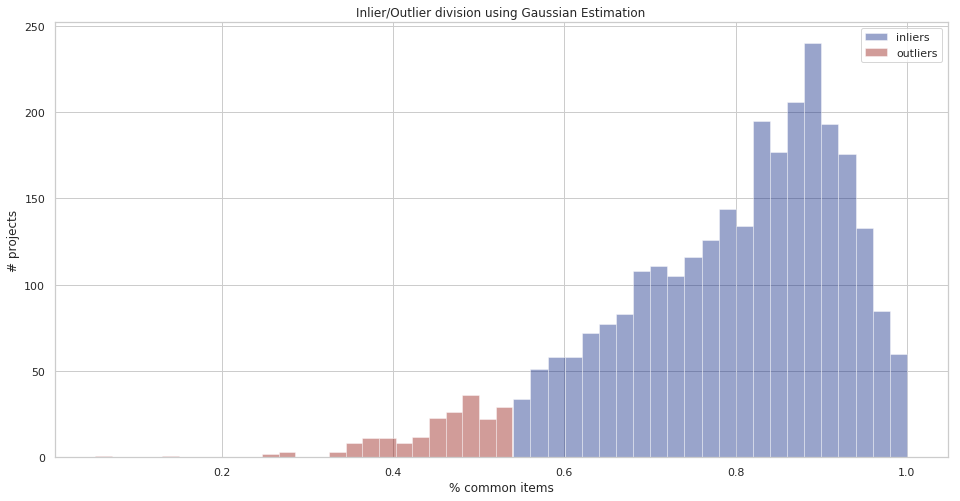

In [54]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,8))

inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) * 50 + 1))
sns.distplot(inliers, label="inliers", color="b", kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) * 50 + 1))
sns.distplot(outliers, label="outliers", color="r", kde=False, bins=bins)

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('% common items')
plt.title('Inlier/Outlier division using Gaussian Estimation')

### Análise LOF

In [55]:
def to_2D(x):
    ''' Given a pd.Series, return a "2D" np.Array with zeros in one dimension.
    '''
    shape = (len(x),1)
    return np.hstack([np.array(x.tolist()).reshape(shape), np.zeros(shape)])

In [58]:
from sklearn.neighbors import LocalOutlierFactor

# Same expected outliers percentual as gaussian method
contamination = 2 * (1 - scipy.stats.norm(0,1).cdf(k))

# Work well for LOF
n_neighbors = 20 # max(20, int(len(projects_train)/100))

# Convert sets to LOF standard
X_train = to_2D(projects_train)
X_test = to_2D(projects_test)

# Get inliers of the training set with LOF Outlier Detection
lof_OD = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
y_train = lof_OD.fit_predict(X_train)
X_train = X_train[y_train == 1, :]

# Train model with LOF Novelty Detection, using train set inliers
# Parameter 'contamination' does not matter at this point
lof_ND = LocalOutlierFactor(novelty=True, contamination=0.5)
lof_ND = lof_ND.fit(X_train)

# Predict outliers from test set
y_test = lof_ND.predict(X_test)
inlier_filter = (y_test == 1)

# Output results
contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

Percentual de outliers esperado: 7.19%
Percentual de outliers encontrado: 36.39%


Text(0.5,1,'Inlier/Outlier division using LOF Estimation')

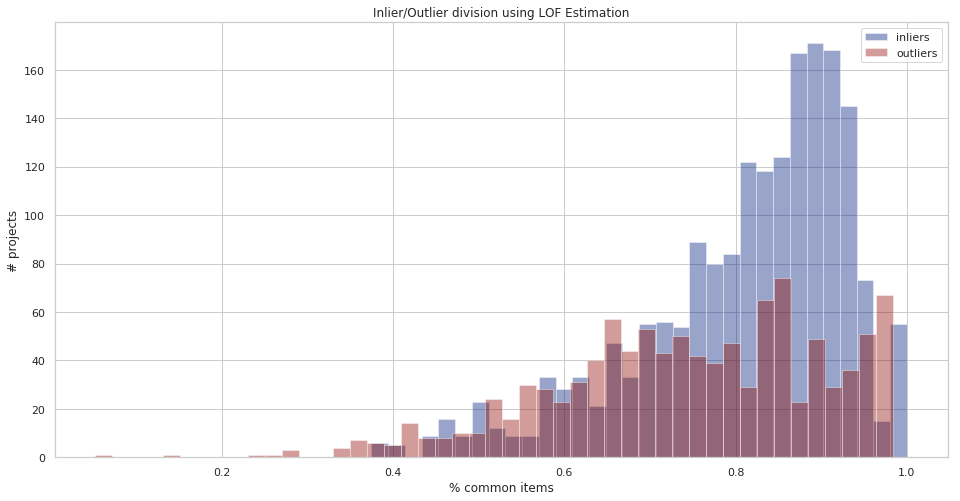

In [59]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,8))

inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) * 50 + 1))
sns.distplot(inliers, label="inliers", color="b", kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) * 50 + 1))
sns.distplot(outliers, label="outliers", color="r", kde=False, bins=bins)

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('% common items')
plt.title('Inlier/Outlier division using LOF Estimation')

### Avaliando a contaminação para cada um dos métodos

Nesta seção, os métodos Gaussiano e LOF são aplicados a 100 escolhas diferentes de conjuntos de treino/teste. Ao final, o desempenho de cada método é avaliado.

In [43]:
percentuals = {'gaussian': [], 'lof': []}

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)
    
    # Parameters
    k = 1.8
    contamination = 2 * (1 - scipy.stats.norm(expected_mean, expected_std).cdf(upper_limit))

    # GAUSSIAN
    lower_limit = expected_mean - k * expected_std
    upper_limit = expected_mean + k * expected_std
    inlier_filter = ((projects_test >= lower_limit) & (projects_test <= upper_limit))
    
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['gaussian'].append(100 * contamination_found)
    
    # LOF
    # Convert sets to LOF standard
    X_train = to_2D(projects_train)
    X_test = to_2D(projects_test)

    # Get inliers of the training set with LOF Outlier Detection
    lof_OD = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.5)
    y_train = lof_OD.fit_predict(X_train)
    X_train = X_train[y_train == 1, :]

    # Train model with LOF Novelty Detection, using train set inliers
    lof_ND = LocalOutlierFactor(novelty=True, contamination=contamination)
    lof_ND = lof_ND.fit(X_train)

    # Predict outliers from test set
    y_test = lof_ND.predict(X_test)
    inlier_filter = (y_test == 1)
    
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['lof'].append(100 * contamination_found)

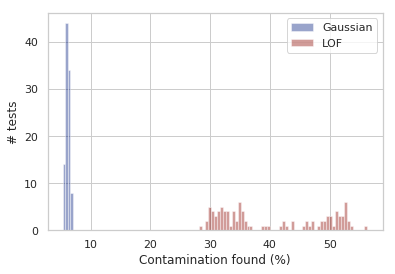

In [44]:
sns.set(style='whitegrid', palette='dark')

gauss = percentuals['gaussian']
bins = max(1, int((max(gauss) - min(gauss)) * 2) + 1)
sns.distplot(gauss, label="Gaussian", color="b", kde=False, bins=bins)

lof = percentuals['lof']
bins = max(1, int((max(lof) - min(lof)) * 2) + 1)
sns.distplot(lof, label="LOF", color="r", kde=False, bins=bins)

# plt.hist(percentuals['gaussian'], bins=20, label='Gaussian')
# plt.hist(percentuals['lof'], bins=20, label='LOF')

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

#### Conclusões

O dataset possiu uma distribuição próxima a uma Gaussiana e o percentual de contaminação encontrado pela Gaussiana se mostrou mais próxima do valor esperado que a estimação de contaminação encontrada pelo LOF.

Outro ponto importante a se notar é a marcação de projetos como inlier/outlier em ambos os estimadores. Na estimação Gaussiana, os projetos são marcados como outlier apenas se a quantidade de itens deste projeto está fora de um intervalo de valores aceitáveis. Já no estimador LOF, se um projeto tem uma quantidade específica de itens que é menos comum relativamente que seus vizinhos (projetos com um percentual de itens entre os mais comuns parecida com a do projeto analisado), então o projeto pode ser marcado como outlier, o que não parece fazer sentido neste contexto.